In [ ]:
#Step 4 - Feature Engineering & Feature Selection 
#Step 5 - Model
'''
In this notebook we are going to do some Feature Engineering & Feature Selection to better capture the patterns in our dataset,
and use them wisely in our predictive model, after that we are going to try and fine-tune the model to get better results.
'''

In [16]:
import pandas as pd

df = pd.read_pickle('df_cleaned_with_outliers.pkl')
df.head()

,ID,Source,Severity,Start_Time,End_Time,Start_Lat,Start_Lng,End_Lat,End_Lng,Distance(mi),...,End_Year,End_Month,End_Day,End_DayOfWeek,End_Hour,End_Minute,End_Second,End_IsWeekend,Duration_Minutes,Duration_Hours
0,A1,Source2,3,2016-02-08 05:46:00,2016-02-08 11:00:00,39.865147,-84.058723,NaN,NaN,0.01,...,2016.0,2.0,8.0,0.0,11.0,0.0,0.0,0,314.0,5.233333
1,A2,Source2,2,2016-02-08 06:07:59,2016-02-08 06:37:59,39.928059,-82.831184,NaN,NaN,0.01,...,2016.0,2.0,8.0,0.0,6.0,37.0,59.0,0,30.0,0.500000
2,A3,Source2,2,2016-02-08 06:49:27,2016-02-08 07:19:27,39.063148,-84.032608,NaN,NaN,0.01,...,2016.0,2.0,8.0,0.0,7.0,19.0,27.0,0,30.0,0.500000
3,A4,Source2,3,2016-02-08 07:23:34,2016-02-08 07:53:34,39.747753,-84.205582,NaN,NaN,0.01,...,2016.0,2.0,8.0,0.0,7.0,53.0,34.0,0,30.0,0.500000
4,A5,Source2,2,2016-02-08 07:39:07,2016-02-08 08:09:07,39.627781,-84.188354,NaN,NaN,0.01,...,2016.0,2.0,8.0,0.0,8.0,9.0,7.0,0,30.0,0.500000


In [17]:
df.shape

(7728394, 64)

In [18]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7728394 entries, 0 to 7728393
Data columns (total 64 columns):
 #   Column                 Dtype         
---  ------                 -----         
 0   ID                     string        
 1   Source                 category      
 2   Severity               category      
 3   Start_Time             datetime64[ns]
 4   End_Time               datetime64[ns]
 5   Start_Lat              float64       
 6   Start_Lng              float64       
 7   End_Lat                float64       
 8   End_Lng                float64       
 9   Distance(mi)           float64       
 10  Description            string        
 11  Street                 string        
 12  City                   string        
 13  County                 string        
 14  State                  string        
 15  Zipcode                string        
 16  Country                string        
 17  Timezone               string        
 18  Airport_Code          

In [19]:
#target value; duration_minutes

df.Duration_Minutes

0          314.000000
1           30.000000
2           30.000000
3           30.000000
4           30.000000
              ...    
7728389     28.600000
7728390     26.883333
7728391     28.466667
7728392     29.350000
7728393     29.416667
Name: Duration_Minutes, Length: 7728394, dtype: float64

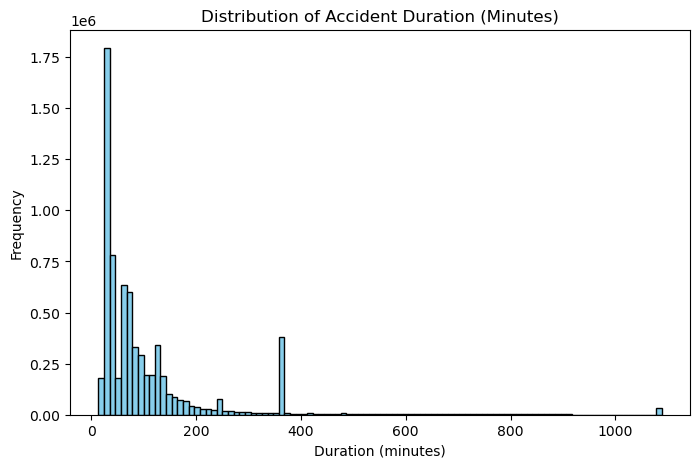

In [20]:
#histogram plot to understant the target variable better;  

import matplotlib.pyplot as plt

plt.figure(figsize=(8,5))
plt.hist(df['Duration_Minutes'], bins=100, color='skyblue', edgecolor='black')
plt.title('Distribution of Accident Duration (Minutes)')
plt.xlabel('Duration (minutes)')
plt.ylabel('Frequency')
plt.show()


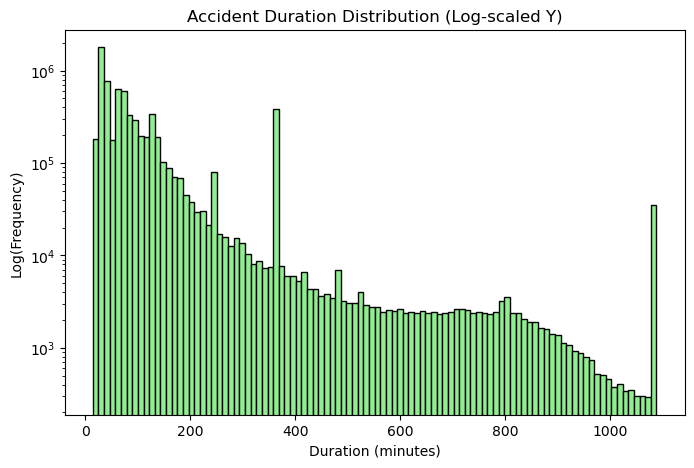

In [21]:
#histogram plot with log to reduce long tail effect

plt.figure(figsize=(8,5))
plt.hist(df['Duration_Minutes'], bins=100, color='lightgreen', edgecolor='black')
plt.yscale('log')
plt.title('Accident Duration Distribution (Log-scaled Y)')
plt.xlabel('Duration (minutes)')
plt.ylabel('Log(Frequency)')
plt.show()


In [22]:
df = df.drop(columns=['Duration_Hours', 'End_Hour', 'End_Year', 'End_Month', 'End_Day', 'End_Minute', 'End_Second', 'End_DayOfWeek'])


In [23]:
df['Duration_Minutes'].mean()

109.86229359876786

In [24]:
#========================================
# Accidents Duration Prediction Pipeline (Enhanced)
#========================================
import pandas as pd
import numpy as np
import sklearn.metrics as metrics
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor, AdaBoostRegressor, GradientBoostingRegressor
import xgboost as xgb
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings("ignore", category=FutureWarning)


class AccidentDurationPipeline_2:
    """
    Pipeline for predicting accident duration using numeric and boolean features.
    Assumes categorical columns are already encoded.
    """

    def __init__(self, target_column='Duration_Minutes', random_state=42):
        self.target_column = target_column
        self.random_state = random_state
        self.models_results = pd.DataFrame()
        self.best_model = None
        self.scaler = StandardScaler()
        self.X_train = None
        self.X_test = None
        self.y_train = None
        self.y_test = None

    # ----------------- Preprocessing -----------------
    def preprocess_data(self, df):
        df_processed = df.copy()
        
        # Drop rows with null target
        df_processed = df_processed.dropna(subset=[self.target_column])
        
        # Select numeric/boolean columns only
        numeric_cols = df_processed.select_dtypes(include=['int64', 'float64']).columns.tolist()
        bool_cols = df_processed.select_dtypes(include=['bool']).columns.tolist()
        df_processed = df_processed[numeric_cols + bool_cols]
        
        # Fill remaining NaNs with median
        from sklearn.impute import SimpleImputer
        imputer = SimpleImputer(strategy='median')
        df_processed[:] = imputer.fit_transform(df_processed)
        
        return df_processed

    # ----------------- Train/Test Split -----------------
    def split_data(self, df, test_size=0.2):
        X = df.drop(columns=[self.target_column])
        y = df[self.target_column]
        self.X_train, self.X_test, self.y_train, self.y_test = train_test_split(
            X, y, test_size=test_size, random_state=self.random_state
        )
        return X, y

    # ----------------- Regression Metrics -----------------
    def regression_metrics(self, y_true, y_pred):
        return {
            'MSE': metrics.mean_squared_error(y_true, y_pred),
            'RMSE': np.sqrt(metrics.mean_squared_error(y_true, y_pred)),
            'MAE': metrics.mean_absolute_error(y_true, y_pred),
            'R2': metrics.r2_score(y_true, y_pred)
        }

    # ----------------- Model Training -----------------
    def train_and_evaluate_models(self, with_cv=True, use_test_set=True):
        models = {
            'Linear Regression': LinearRegression(),
            'Decision Tree': DecisionTreeRegressor(random_state=self.random_state, max_depth=10),
            'Random Forest': RandomForestRegressor(random_state=self.random_state, n_estimators=100, max_depth=20),
            'AdaBoost': AdaBoostRegressor(random_state=self.random_state, n_estimators=50),
            'Gradient Boosting': GradientBoostingRegressor(random_state=self.random_state, n_estimators=100),
            'XGBoost': xgb.XGBRegressor(random_state=self.random_state, n_estimators=100, max_depth=6)
        }

        results_list = []
        for name, model in models.items():
            cv_rmse_mean, cv_rmse_std = None, None
            if with_cv:
                cv_scores = cross_val_score(model, self.X_train, self.y_train, cv=5,
                                            scoring='neg_root_mean_squared_error', n_jobs=-1)
                cv_rmse_mean = -cv_scores.mean()
                cv_rmse_std = cv_scores.std()

            model.fit(self.X_train, self.y_train)
            X_eval, y_eval = (self.X_test, self.y_test) if use_test_set else (self.X_train, self.y_train)
            pred = model.predict(X_eval)
            metrics_dict = self.regression_metrics(y_eval, pred)
            results_list.append({
                'model': name,
                'eval_set': 'Test Set' if use_test_set else 'Train Set',
                'cv_rmse': cv_rmse_mean,
                'cv_std': cv_rmse_std,
                **metrics_dict
            })

        self.models_results = pd.DataFrame(results_list)
        return self.models_results

    # ----------------- Fine-tuning -----------------
    def fine_tune_model(self, model_name='RandomForest', param_grid=None, cv=3, scoring='neg_mean_squared_error'):
        if model_name=='RandomForest':
            base_model = RandomForestRegressor(random_state=self.random_state)
            if param_grid is None:
                param_grid = {
                    'n_estimators':[50,100,200],
                    'max_depth':[10,20,30,None],
                    'min_samples_split':[2,5,10],
                    'min_samples_leaf':[1,2,4],
                    'max_features':['sqrt','log2']
                }
        elif model_name=='XGBoost':
            base_model = xgb.XGBRegressor(random_state=self.random_state)
            if param_grid is None:
                param_grid = {
                    'n_estimators':[50,100,200],
                    'max_depth':[3,6,9],
                    'learning_rate':[0.01,0.1,0.3],
                    'subsample':[0.8,1.0],
                    'colsample_bytree':[0.8,1.0]
                }
        else:
            raise ValueError("model_name must be 'RandomForest' or 'XGBoost'")

        gs = GridSearchCV(base_model, param_grid=param_grid, cv=cv, n_jobs=-1, verbose=1, scoring=scoring)
        gs.fit(self.X_train, self.y_train)
        self.best_model = gs
        return gs

    # ----------------- Add Tuned Model Results -----------------
    def add_tuned_model_results(self, grid_search, model_name):
        pred = grid_search.predict(self.X_test)
        metrics_dict = self.regression_metrics(self.y_test, pred)
        row = pd.DataFrame([{'model': model_name, 'eval_set': 'Test Set', **metrics_dict}])
        self.models_results = pd.concat([self.models_results,row], ignore_index=True)
        return self.models_results

    # ----------------- Feature Importance -----------------
    def get_feature_importance(self, top_n=20):
        if self.best_model is None:
            print("No tuned model available.")
            return None
        model = self.best_model.best_estimator_
        if hasattr(model,'feature_importances_'):
            df = pd.DataFrame({'feature':self.X_train.columns,'importance':model.feature_importances_})
            return df.sort_values('importance',ascending=False).head(top_n)
        else:
            print("Model has no feature_importances_ attribute")
            return None

    # ----------------- Plot Evaluation -----------------
    def plot_evaluation(self, model=None):
        if model is None:
            if self.best_model is not None:
                model = self.best_model.best_estimator_
            else:
                print("No model provided or tuned model found.")
                return
        y_pred = model.predict(self.X_test)
        rmse = np.sqrt(metrics.mean_squared_error(self.y_test, y_pred))
        mae = metrics.mean_absolute_error(self.y_test, y_pred)
        r2 = metrics.r2_score(self.y_test, y_pred)
        print(f"RMSE: {rmse:.3f} | MAE: {mae:.3f} | R2: {r2:.3f}")
        plt.figure(figsize=(6,6))
        plt.scatter(self.y_test, y_pred, alpha=0.4, color='teal')
        plt.plot([self.y_test.min(),self.y_test.max()],
                 [self.y_test.min(),self.y_test.max()],'r--')
        plt.xlabel("Actual Duration (min)")
        plt.ylabel("Predicted Duration (min)")
        plt.title("Predicted vs Actual Accident Duration")
        plt.show()


In [25]:

# ===============================
# Run full pipeline in one go
# ===============================

# Limit rows to speed up testing
df_run = df.sample(n=10000, random_state=42)

# 1️⃣ Initialize
pipeline = AccidentDurationPipeline_2(target_column='Duration_Minutes', random_state=42)

# 2️⃣ Preprocess
df_processed = pipeline.preprocess_data(df_run)


# 3️⃣ Split data
X, y = pipeline.split_data(df_processed, test_size=0.2)
print(f"\n✅ Train shape: {pipeline.X_train.shape}, Test shape: {pipeline.X_test.shape}")


# 5️⃣ Train & evaluate models
results = pipeline.train_and_evaluate_models(with_cv=True, use_test_set=True)
print("\n✅ Model evaluation results:")
print(results.sort_values('RMSE'))





✅ Train shape: (7232, 34), Test shape: (1809, 34)

✅ Model evaluation results:
               model  eval_set     cv_rmse     cv_std           MSE  \
5            XGBoost  Test Set  111.933093   4.281962  12908.551294   
4  Gradient Boosting  Test Set  111.304860   5.601088  13136.668008   
2      Random Forest  Test Set  109.275927   6.134352  13441.184977   
1      Decision Tree  Test Set  136.151911   7.430353  17988.318732   
0  Linear Regression  Test Set  132.858080   6.309955  20296.731210   
3           AdaBoost  Test Set  171.968223  15.594600  26075.275356   

         RMSE         MAE        R2  
5  113.615806   55.859280  0.402582  
4  114.615304   57.427745  0.392025  
2  115.936125   55.182559  0.377931  
1  134.120538   57.891633  0.167487  
0  142.466597   81.180010  0.060651  
3  161.478405  114.183877 -0.206784  


Fitting 3 folds for each of 108 candidates, totalling 324 fits

✅ Model results after fine-tuning:
               model  eval_set     cv_rmse     cv_std           MSE  \
6      XGBoost_Tuned  Test Set         NaN        NaN  11824.046640   
5            XGBoost  Test Set  111.933093   4.281962  12908.551294   
4  Gradient Boosting  Test Set  111.304860   5.601088  13136.668008   
2      Random Forest  Test Set  109.275927   6.134352  13441.184977   
1      Decision Tree  Test Set  136.151911   7.430353  17988.318732   
0  Linear Regression  Test Set  132.858080   6.309955  20296.731210   
3           AdaBoost  Test Set  171.968223  15.594600  26075.275356   

         RMSE         MAE        R2  
6  108.738432   52.012895  0.452774  
5  113.615806   55.859280  0.402582  
4  114.615304   57.427745  0.392025  
2  115.936125   55.182559  0.377931  
1  134.120538   57.891633  0.167487  
0  142.466597   81.180010  0.060651  
3  161.478405  114.183877 -0.206784  

✅ Top 20 features by import

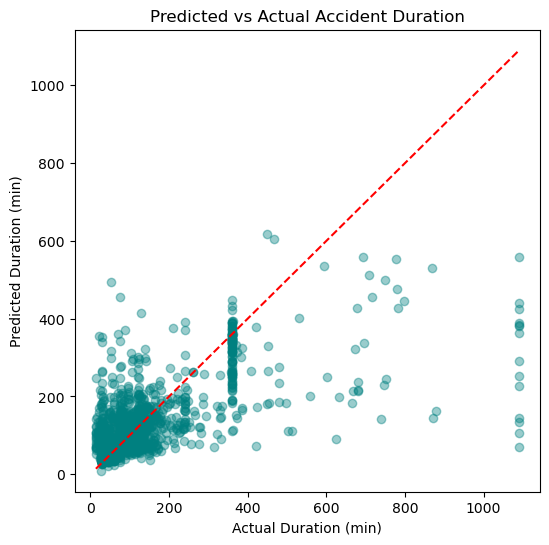

In [26]:
# 6️⃣ Fine-tune best model (XGBoost)
tuned = pipeline.fine_tune_model(model_name='XGBoost')
pipeline.add_tuned_model_results(tuned, 'XGBoost_Tuned')

print("\n✅ Model results after fine-tuning:")
print(pipeline.models_results.sort_values('RMSE'))

# 7️⃣ Feature importance
importance = pipeline.get_feature_importance(top_n=20)
print("\n✅ Top 20 features by importance:")
print(importance)

# 8️⃣ Evaluation plot
pipeline.plot_evaluation()  # uses best tuned model by default


In [27]:
#========================================
# Accidents Duration Prediction Pipeline (Enhanced with New Features)
#========================================
import pandas as pd
import numpy as np
import sklearn.metrics as metrics
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor, AdaBoostRegressor, GradientBoostingRegressor
import xgboost as xgb
import matplotlib.pyplot as plt
from sklearn.impute import SimpleImputer
import warnings
warnings.filterwarnings("ignore", category=FutureWarning)


class AccidentDurationPipeline_2:
    """
    Pipeline for predicting accident duration with enhanced features.
    Categorical columns are encoded automatically.
    """

    def __init__(self, target_column='Duration_Minutes', random_state=42):
        self.target_column = target_column
        self.random_state = random_state
        self.models_results = pd.DataFrame()
        self.best_model = None
        self.scaler = StandardScaler()
        self.label_encoders = {}
        self.X_train = None
        self.X_test = None
        self.y_train = None
        self.y_test = None

    # ----------------- Preprocessing -----------------
    def preprocess_data(self, df, drop_na=True):
        df = df.copy()
        
        # Drop rows with null target
        if drop_na:
            df = df.dropna(subset=[self.target_column])

        # Log-transform target
        df.loc[:, 'Log_Duration'] = np.log1p(df[self.target_column])

        # ----------------- Feature Engineering -----------------
        # Temporal interaction
        if {'Start_Hour', 'Start_DayOfWeek'}.issubset(df.columns):
            df.loc[:, 'Hour_x_Weekday'] = df['Start_Hour'] * df['Start_DayOfWeek']

        # Weather interaction
        if {'Temperature(F)', 'Humidity(%)'}.issubset(df.columns):
            df.loc[:, 'Temp_Humidity_Interaction'] = df['Temperature(F)'] * df['Humidity(%)']

        # Road complexity
        road_cols = ['Amenity', 'Bump', 'Crossing', 'Junction', 'No_Exit', 
                     'Railway', 'Station', 'Stop', 'Traffic_Signal']
        road_cols = [col for col in road_cols if col in df.columns]
        if road_cols:
            df.loc[:, 'Has_Traffic_Control'] = df[road_cols].any(axis=1).astype(int)
            df.loc[:, 'Complex_Road'] = df[road_cols].sum(axis=1)

        # Encode categorical columns
        cat_cols = df.select_dtypes(include=['object', 'category']).columns
        for col in cat_cols:
            le = LabelEncoder()
            df.loc[:, col] = le.fit_transform(df[col].astype(str).fillna('Unknown'))
            self.label_encoders[col] = le

        # Keep numeric columns only
        numeric_cols = df.select_dtypes(include=[np.number]).columns.tolist()
        df = df[numeric_cols]

        # Impute missing values
        imputer = SimpleImputer(strategy='median')
        df.loc[:, numeric_cols] = imputer.fit_transform(df[numeric_cols])

        print(f"✅ Preprocessed shape: {df.shape}")
        return df

    # ----------------- Train/Test Split -----------------
    def split_data(self, df, test_size=0.2, use_log_target=True):
        target = 'Log_Duration' if use_log_target and 'Log_Duration' in df.columns else self.target_column
        X = df.drop(columns=[target])
        y = df[target]

        self.X_train, self.X_test, self.y_train, self.y_test = train_test_split(
            X, y, test_size=test_size, random_state=self.random_state
        )

        # Scale numeric features
        self.X_train = pd.DataFrame(self.scaler.fit_transform(self.X_train), columns=X.columns)
        self.X_test = pd.DataFrame(self.scaler.transform(self.X_test), columns=X.columns)

        print(f"✅ Train shape: {self.X_train.shape}, Test shape: {self.X_test.shape}")
        return X, y

    # ----------------- Regression Metrics -----------------
    def regression_metrics(self, y_true, y_pred, original_scale=True):
        if original_scale and 'Log_Duration' in y_true.name:
            y_true = np.expm1(y_true)
            y_pred = np.expm1(y_pred)
        return {
            'MSE': metrics.mean_squared_error(y_true, y_pred),
            'RMSE': np.sqrt(metrics.mean_squared_error(y_true, y_pred)),
            'MAE': metrics.mean_absolute_error(y_true, y_pred),
            'R2': metrics.r2_score(y_true, y_pred)
        }

    # ----------------- Model Training -----------------
    def train_and_evaluate_models(self, with_cv=True, use_test_set=True):
        models = {
            'Linear Regression': LinearRegression(),
            'Decision Tree': DecisionTreeRegressor(random_state=self.random_state, max_depth=10),
            'Random Forest': RandomForestRegressor(random_state=self.random_state, n_estimators=100, max_depth=20),
            'AdaBoost': AdaBoostRegressor(random_state=self.random_state, n_estimators=50),
            'Gradient Boosting': GradientBoostingRegressor(random_state=self.random_state, n_estimators=100),
            'XGBoost': xgb.XGBRegressor(random_state=self.random_state, n_estimators=100, max_depth=6)
        }

        results_list = []
        for name, model in models.items():
            cv_rmse_mean, cv_rmse_std = None, None
            if with_cv:
                cv_scores = cross_val_score(model, self.X_train, self.y_train, cv=5,
                                            scoring='neg_root_mean_squared_error', n_jobs=-1)
                cv_rmse_mean = -cv_scores.mean()
                cv_rmse_std = cv_scores.std()

            model.fit(self.X_train, self.y_train)
            X_eval, y_eval = (self.X_test, self.y_test) if use_test_set else (self.X_train, self.y_train)
            pred = model.predict(X_eval)
            metrics_dict = self.regression_metrics(y_eval, pred)
            results_list.append({
                'model': name,
                'eval_set': 'Test Set' if use_test_set else 'Train Set',
                'cv_rmse': cv_rmse_mean,
                'cv_std': cv_rmse_std,
                **metrics_dict
            })

        self.models_results = pd.DataFrame(results_list)

        # Select best model automatically
        best_idx = results_list.index(min(results_list, key=lambda x: x['RMSE']))
        best_model_name = results_list[best_idx]['model']
        self.best_model = models[best_model_name]
        
        return self.models_results


    # ----------------- Fine-tuning -----------------
    def fine_tune_model(self, model_name='RandomForest', param_grid=None, cv=3, scoring='neg_mean_squared_error'):
        if model_name=='RandomForest':
            base_model = RandomForestRegressor(random_state=self.random_state)
            if param_grid is None:
                param_grid = {
                    'n_estimators':[50,100,200],
                    'max_depth':[10,20,30,None],
                    'min_samples_split':[2,5,10],
                    'min_samples_leaf':[1,2,4],
                    'max_features':['sqrt','log2']
                }
        elif model_name=='XGBoost':
            base_model = xgb.XGBRegressor(random_state=self.random_state)
            if param_grid is None:
                param_grid = {
                    'n_estimators':[50,100,200],
                    'max_depth':[3,6,9],
                    'learning_rate':[0.01,0.1,0.3],
                    'subsample':[0.8,1.0],
                    'colsample_bytree':[0.8,1.0]
                }
        else:
            raise ValueError("model_name must be 'RandomForest' or 'XGBoost'")

        gs = GridSearchCV(base_model, param_grid=param_grid, cv=cv, n_jobs=-1, verbose=1, scoring=scoring)
        gs.fit(self.X_train, self.y_train)
        self.best_model = gs
        return gs

    # ----------------- Add Tuned Model Results -----------------
    def add_tuned_model_results(self, grid_search, model_name):
        pred = grid_search.predict(self.X_test)
        metrics_dict = self.regression_metrics(self.y_test, pred)
        row = pd.DataFrame([{'model': model_name, 'eval_set': 'Test Set', **metrics_dict}])
        self.models_results = pd.concat([self.models_results,row], ignore_index=True)
        return self.models_results

    # ----------------- Feature Importance -----------------
    def get_feature_importance(self, top_n=20):
        if self.best_model is None:
            print("No tuned model available.")
            return None
        model = self.best_model.best_estimator_
        if hasattr(model,'feature_importances_'):
            df = pd.DataFrame({'feature':self.X_train.columns,'importance':model.feature_importances_})
            return df.sort_values('importance',ascending=False).head(top_n)
        else:
            print("Model has no feature_importances_ attribute")
            return None

    # ----------------- Plot Evaluation -----------------
    def plot_evaluation(self, model=None):
        if model is None:
            if self.best_model is not None:
                model = self.best_model
            else:
                print("No model provided or tuned model found.")
                return
    
        # If model is a GridSearchCV, get the best estimator
        if hasattr(model, 'best_estimator_'):
            model_to_use = model.best_estimator_
        else:
            model_to_use = model
    
        y_pred = model_to_use.predict(self.X_test)
        rmse = np.sqrt(metrics.mean_squared_error(self.y_test, y_pred))
        mae = metrics.mean_absolute_error(self.y_test, y_pred)
        r2 = metrics.r2_score(self.y_test, y_pred)
    
        print(f"RMSE: {rmse:.3f} | MAE: {mae:.3f} | R2: {r2:.3f}")
        plt.figure(figsize=(6,6))
        plt.scatter(self.y_test, y_pred, alpha=0.4, color='teal')
        plt.plot([self.y_test.min(), self.y_test.max()],
                 [self.y_test.min(), self.y_test.max()], 'r--')
        plt.xlabel("Actual Duration (min)")
        plt.ylabel("Predicted Duration (min)")
        plt.title("Predicted vs Actual Accident Duration")
        plt.show()



✅ Preprocessed shape: (9041, 35)
✅ Train shape: (7232, 34), Test shape: (1809, 34)

✅ Model evaluation results (sorted by RMSE):
               model  eval_set   cv_rmse    cv_std            MSE        RMSE  \
2      Random Forest  Test Set  0.002272  0.000876       0.538720    0.733975   
4  Gradient Boosting  Test Set  0.005732  0.000249       3.104622    1.761994   
1      Decision Tree  Test Set  0.004224  0.000717       6.486615    2.546883   
5            XGBoost  Test Set  0.005847  0.000369       7.930891    2.816184   
3           AdaBoost  Test Set  0.076488  0.004684     331.162455   18.197870   
0  Linear Regression  Test Set  0.404864  0.012824  623736.246095  789.769742   

          MAE         R2  
2    0.127959   0.999975  
4    0.514407   0.999856  
1    0.347998   0.999700  
5    0.538964   0.999633  
3    7.034942   0.984674  
0  107.665627 -27.867001  
RMSE: 0.002 | MAE: 0.001 | R2: 1.000


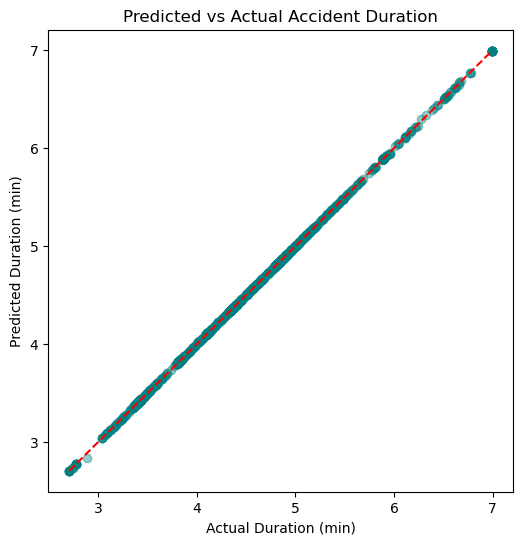

In [28]:
# ----------------- Sample & Run Pipeline -----------------
# Limit to 10,000 rows for faster testing
df_sample = df.sample(n=10000, random_state=42).reset_index(drop=True)

# Initialize pipeline
pipeline = AccidentDurationPipeline_2(target_column='Duration_Minutes', random_state=42)

# Preprocess data (adds new features)
df_processed = pipeline.preprocess_data(df_sample)

# Split data into train/test and scale
X, y = pipeline.split_data(df_processed, test_size=0.2, use_log_target=True)

# Train and evaluate models with cross-validation
results = pipeline.train_and_evaluate_models(with_cv=True, use_test_set=True)

# Sort results by RMSE and display
print("\n✅ Model evaluation results (sorted by RMSE):")
print(results.sort_values('RMSE'))

# Optional: plot evaluation for the best model
pipeline.plot_evaluation()


In [ ]:
'''overfitting! maybe due to data leakage?'''

In [39]:
# Accidents Duration Prediction Pipeline (fixed)
import pandas as pd
import numpy as np
import sklearn.metrics as metrics
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor, AdaBoostRegressor, GradientBoostingRegressor
import xgboost as xgb
import matplotlib.pyplot as plt
from sklearn.impute import SimpleImputer
import warnings
warnings.filterwarnings("ignore", category=FutureWarning)


class AccidentDurationPipelineFixed:
    def __init__(self, target_column='Duration_Minutes', random_state=42):
        self.target_column = target_column
        self.log_target_name = 'Log_Duration'
        self.random_state = random_state
        self.models_results = pd.DataFrame()
        self.best_model = None          # fitted estimator or GridSearchCV
        self.scaler = StandardScaler()
        self.label_encoders = {}
        self.X_train = None
        self.X_test = None
        self.y_train = None
        self.y_test = None
        self.fitted_models = {}         # store fitted instances

    # ----------------- Preprocessing -----------------
    def preprocess_data(self, df, drop_na=True):
        df = df.copy()

        # Drop rows with null target
        if drop_na:
            df = df.dropna(subset=[self.target_column])

        # Log-transform target
        df.loc[:, self.log_target_name] = np.log1p(df[self.target_column].astype(float))

        # Feature engineering (kept same as original)
        if {'Start_Hour', 'Start_DayOfWeek'}.issubset(df.columns):
            df.loc[:, 'Hour_x_Weekday'] = df['Start_Hour'] * df['Start_DayOfWeek']

        if {'Temperature(F)', 'Humidity(%)'}.issubset(df.columns):
            df.loc[:, 'Temp_Humidity_Interaction'] = df['Temperature(F)'] * df['Humidity(%)']

        road_cols = ['Amenity', 'Bump', 'Crossing', 'Junction', 'No_Exit',
                     'Railway', 'Station', 'Stop', 'Traffic_Signal']
        road_cols = [col for col in road_cols if col in df.columns]
        if road_cols:
            df.loc[:, 'Has_Traffic_Control'] = df[road_cols].any(axis=1).astype(int)
            df.loc[:, 'Complex_Road'] = df[road_cols].sum(axis=1)

        # Encode categorical columns (store LabelEncoders)
        cat_cols = df.select_dtypes(include=['object', 'category']).columns
        for col in cat_cols:
            le = LabelEncoder()
            df.loc[:, col] = le.fit_transform(df[col].astype(str).fillna('Unknown'))
            self.label_encoders[col] = le

        # Keep numeric columns only (will include target columns temporarily)
        numeric_cols = df.select_dtypes(include=[np.number]).columns.tolist()

        # Impute missing numeric values
        imputer = SimpleImputer(strategy='median')
        df.loc[:, numeric_cols] = imputer.fit_transform(df[numeric_cols])

        # Keep only numeric columns (models can’t handle strings)
        df = df.select_dtypes(include=[np.number])


        print(f"✅ Preprocessed shape: {df.shape}")
        return df

    # ----------------- Train/Test Split -----------------

    def split_data(self, df, test_size=0.2, use_log_target=True):
        """
        Split data into train and test sets, ensuring only numeric features are scaled.
        """
        # Decide which target to use
        target = self.log_target_name if use_log_target and self.log_target_name in df.columns else self.target_column

        # Drop both target versions if both exist
        drop_cols = [target]
        if self.target_column in df.columns and self.target_column != target:
            drop_cols.append(self.target_column)

        X = df.drop(columns=drop_cols)
        y = df[target].copy()

        # --- Split into train and test ---
        self.X_train, self.X_test, self.y_train, self.y_test = train_test_split(
            X, y, test_size=test_size, random_state=self.random_state
        )

        # --- Identify numeric columns only ---
        numeric_cols = self.X_train.select_dtypes(include=[np.number]).columns
        non_numeric_cols = [col for col in X.columns if col not in numeric_cols]

        # --- Scale numeric features only ---
        self.X_train[numeric_cols] = self.scaler.fit_transform(self.X_train[numeric_cols])
        self.X_test[numeric_cols] = self.scaler.transform(self.X_test[numeric_cols])

        print(f"✅ Train shape: {self.X_train.shape}, Test shape: {self.X_test.shape}")
        if non_numeric_cols:
            print(f"ℹ️ Skipped scaling for non-numeric columns: {non_numeric_cols}")

        return X, y


    # ----------------- Regression Metrics -----------------
    def regression_metrics(self, y_true, y_pred, y_are_logs=False):
        """
        If y_are_logs=True, y_true and y_pred are in log1p space and will be inverse-transformed
        before computing MSE/RMSE/MAE/R2 on original minutes.
        """
        if y_are_logs:
            y_true_orig = np.expm1(y_true)
            y_pred_orig = np.expm1(y_pred)
        else:
            y_true_orig = y_true
            y_pred_orig = y_pred

        mse = metrics.mean_squared_error(y_true_orig, y_pred_orig)
        rmse = np.sqrt(mse)
        mae = metrics.mean_absolute_error(y_true_orig, y_pred_orig)
        r2 = metrics.r2_score(y_true_orig, y_pred_orig)
        return {'MSE': mse, 'RMSE': rmse, 'MAE': mae, 'R2': r2}

    # ----------------- Model Training -----------------
    def train_and_evaluate_models(self, with_cv=True, use_test_set=True):
        models = {
            'Linear Regression': LinearRegression(),
            'Decision Tree': DecisionTreeRegressor(random_state=self.random_state, max_depth=10),
            'Random Forest': RandomForestRegressor(random_state=self.random_state, n_estimators=100, max_depth=20),
            'AdaBoost': AdaBoostRegressor(random_state=self.random_state, n_estimators=50),
            'Gradient Boosting': GradientBoostingRegressor(random_state=self.random_state, n_estimators=100),
            'XGBoost': xgb.XGBRegressor(random_state=self.random_state, n_estimators=100, max_depth=6, verbosity=0)
        }

        results_list = []
        self.fitted_models = {}

        for name, model in models.items():
            cv_rmse_mean, cv_rmse_std = None, None
            if with_cv:
                # cross_val_score on training set; note scoring returns NEG values for "neg_root_mean_squared_error"
                cv_scores = cross_val_score(model, self.X_train, self.y_train, cv=5,
                                            scoring='neg_root_mean_squared_error', n_jobs=-1)
                cv_rmse_mean = -cv_scores.mean()
                cv_rmse_std = cv_scores.std()

            # fit and store fitted model instance
            model.fit(self.X_train, self.y_train)
            self.fitted_models[name] = model

            # choose evaluation set
            X_eval, y_eval = (self.X_test, self.y_test) if use_test_set else (self.X_train, self.y_train)
            pred = model.predict(X_eval)

            # y_train/y_test are in log-space if you used log target earlier; detect and compute metrics on original minutes
            y_are_logs = (self.y_test.name == self.log_target_name) if use_test_set else (self.y_train.name == self.log_target_name)
            metrics_dict = self.regression_metrics(y_eval, pred, y_are_logs)

            results_list.append({
                'model': name,
                'eval_set': 'Test Set' if use_test_set else 'Train Set',
                'cv_rmse': cv_rmse_mean,
                'cv_std': cv_rmse_std,
                **metrics_dict
            })

        self.models_results = pd.DataFrame(results_list)

        # Select best model by RMSE (lower is better) and set fitted best_model
        best_entry = min(results_list, key=lambda x: x['RMSE'])
        best_model_name = best_entry['model']
        self.best_model = self.fitted_models.get(best_model_name, None)

        print("✅ Model evaluation results (sorted by RMSE):")
        print(self.models_results.sort_values('RMSE').reset_index(drop=True))
        return self.models_results

    # ----------------- Fine-tuning -----------------
    def fine_tune_model(self, model_name='RandomForest', param_grid=None, cv=3, scoring='neg_mean_squared_error'):
        if model_name == 'RandomForest':
            base_model = RandomForestRegressor(random_state=self.random_state)
            if param_grid is None:
                param_grid = {
                    'n_estimators': [50, 100, 200],
                    'max_depth': [10, 20, 30, None],
                    'min_samples_split': [2, 5, 10],
                    'min_samples_leaf': [1, 2, 4],
                    'max_features': ['sqrt', 'log2']
                }
        elif model_name == 'XGBoost':
            base_model = xgb.XGBRegressor(random_state=self.random_state, verbosity=0)
            if param_grid is None:
                param_grid = {
                    'n_estimators': [50, 100, 200],
                    'max_depth': [3, 6, 9],
                    'learning_rate': [0.01, 0.1, 0.3],
                    'subsample': [0.8, 1.0],
                    'colsample_bytree': [0.8, 1.0]
                }
        else:
            raise ValueError("model_name must be 'RandomForest' or 'XGBoost'")

        gs = GridSearchCV(base_model, param_grid=param_grid, cv=cv, n_jobs=-1, verbose=1, scoring=scoring)
        gs.fit(self.X_train, self.y_train)
        self.best_model = gs
        return gs

    # ----------------- Add Tuned Model Results -----------------
    def add_tuned_model_results(self, grid_search, model_name):
        pred = grid_search.predict(self.X_test)
        y_are_logs = (self.y_test.name == self.log_target_name)
        metrics_dict = self.regression_metrics(self.y_test, pred, y_are_logs)
        row = pd.DataFrame([{'model': model_name, 'eval_set': 'Test Set', **metrics_dict}])
        self.models_results = pd.concat([self.models_results, row], ignore_index=True)
        return self.models_results

    # ----------------- Feature Importance -----------------
    def get_feature_importance(self, top_n=20):
        if self.best_model is None:
            print("No tuned model available.")
            return None

        # if GridSearchCV, pick best estimator
        if hasattr(self.best_model, 'best_estimator_'):
            model = self.best_model.best_estimator_
        else:
            model = self.best_model

        if hasattr(model, 'feature_importances_'):
            df = pd.DataFrame({'feature': self.X_train.columns, 'importance': model.feature_importances_})
            return df.sort_values('importance', ascending=False).head(top_n)
        else:
            print("Model has no feature_importances_ attribute")
            return None

    # ----------------- Plot Evaluation -----------------
    def plot_evaluation(self, model=None):
        if model is None:
            if self.best_model is not None:
                model = self.best_model
            else:
                print("No model provided or tuned model found.")
                return

        if hasattr(model, 'best_estimator_'):
            model_to_use = model.best_estimator_
        else:
            model_to_use = model

        y_pred = model_to_use.predict(self.X_test)

        # if test-target is in log-space convert to original for plotting & metrics
        y_are_logs = (self.y_test.name == self.log_target_name)
        if y_are_logs:
            y_plot_true = np.expm1(self.y_test)
            y_plot_pred = np.expm1(y_pred)
        else:
            y_plot_true = self.y_test
            y_plot_pred = y_pred

        rmse = np.sqrt(metrics.mean_squared_error(y_plot_true, y_plot_pred))
        mae = metrics.mean_absolute_error(y_plot_true, y_plot_pred)
        r2 = metrics.r2_score(y_plot_true, y_plot_pred)

        print(f"RMSE: {rmse:.3f} | MAE: {mae:.3f} | R2: {r2:.3f}")
        plt.figure(figsize=(6, 6))
        plt.scatter(y_plot_true, y_plot_pred, alpha=0.4)
        plt.plot([y_plot_true.min(), y_plot_true.max()],
                 [y_plot_true.min(), y_plot_true.max()], 'r--')
        plt.xlabel("Actual Duration (min)")
        plt.ylabel("Predicted Duration (min)")
        plt.title("Predicted vs Actual Accident Duration")
        plt.show()


✅ Preprocessed shape: (9041, 35)
✅ Train shape: (7232, 33), Test shape: (1809, 33)
✅ Model evaluation results (sorted by RMSE):
               model  eval_set   cv_rmse    cv_std           MSE        RMSE  \
0      Random Forest  Test Set  0.553037  0.012701  14259.062262  119.411315   
1            XGBoost  Test Set  0.581708  0.016547  14474.573920  120.310323   
2      Decision Tree  Test Set  0.629743  0.015399  14915.288106  122.128163   
3  Gradient Boosting  Test Set  0.599732  0.007103  16318.043925  127.742099   
4           AdaBoost  Test Set  0.711827  0.017445  18993.011415  137.815135   
5  Linear Regression  Test Set  0.720478  0.009088  19693.906653  140.334980   

         MAE        R2  
0  47.032300  0.340079  
1  51.066120  0.330105  
2  48.277127  0.309709  
3  53.556607  0.244788  
4  66.906545  0.120989  
5  65.069745  0.088551  
RMSE: 119.411 | MAE: 47.032 | R2: 0.340


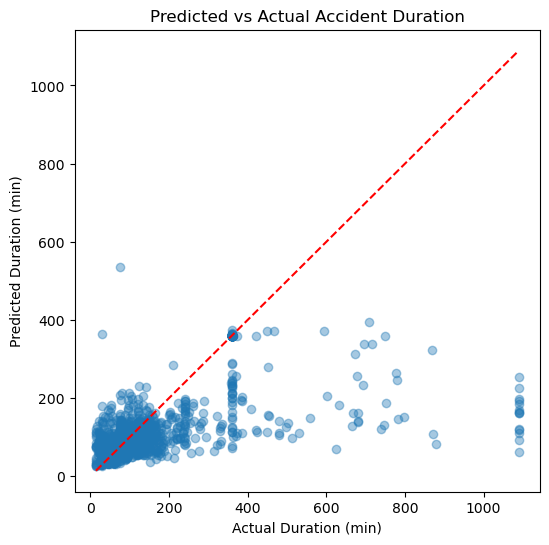

In [41]:
# Limit to 10,000 rows for faster testing
df_sample = df.sample(n=10000, random_state=42).reset_index(drop=True)
pipe = AccidentDurationPipelineFixed(target_column='Duration_Minutes')
df_pre = pipe.preprocess_data(df_sample)         
pipe.split_data(df_pre, test_size=0.2, use_log_target=True)
results = pipe.train_and_evaluate_models(with_cv=True, use_test_set=True)
pipe.plot_evaluation()                           # plots in original-minute scale
